In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

In [2]:
# Load data
test = pd.read_csv("hw3_Data2/test.csv", sep = ",")
train = pd.read_csv("hw3_Data2/train.csv", sep = ",")

In [3]:
# Combine train and test data
data = pd.concat([train, test], axis = 0)
data['Date'] = pd.to_datetime(data.Date, format = '%Y-%m-%d')
data.index = data['Date']
data = data.drop('Date', axis = 1)
# print(data)

In [4]:
# Split Date as index
train['Date'] = pd.to_datetime(train.Date, format = '%Y-%m-%d')
train.index = train['Date']
train = train.drop('Date', axis = 1)

test['Date'] = pd.to_datetime(test.Date, format = '%Y-%m-%d')
test.index = test['Date']
test = test.drop('Date', axis = 1)

In [5]:
# Take "Close" values as training and testing data
train_close = train['Close']
test_close = test['Close']
data_close = data['Close']
# print(type(test_close))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2973.657, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2975.146, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2975.090, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2973.595, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2976.585, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.196 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1485.797
Date:                Mon, 14 Nov 2022   AIC                           2973.595
Time:                        22:44:24   BIC                           2977.006
Sample:                             0   HQIC                          2974.972
                                - 225                                       

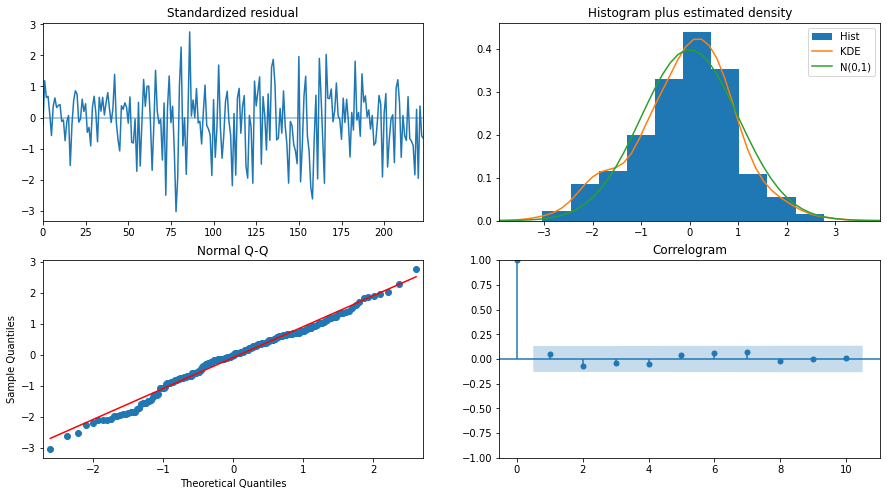

In [6]:
model_autoARIMA = auto_arima(train_close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()
# print(model_autoARIMA.order)#(0, 1, 0)
# print(model_autoARIMA.seasonal_order)#(0, 0, 0, 0)

# model = model_autoARIMA  # seeded from the model we've already fit

In [42]:
# Estimated differencing term d
from pmdarima.arima import ndiffs
kpss_diffs = ndiffs(train_close, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_close, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(f"d is {n_diffs}")


d is 1


In [43]:
# Estimating the seasonal differencing term D
from pmdarima.arima.utils import nsdiffs
# estimate number of seasonal differences using a Canova-Hansen test
D = nsdiffs(train_close, m=10, max_D=12, test='ch')
print("D is {0}".format(0))


D is 0


/var/folders/vg/83f50g8n6m16fkcbjq2qsv8c0000gn/T/ipykernel_59993/210226583.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


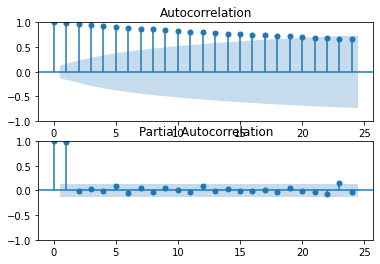

In [37]:
# acf = pm.plot_acf(train_close) # find q for MA
# pacf = pm.plot_pacf(train_close) # find p for AR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(2, 1)
plot_acf(train_close, ax = axes[0])
plot_pacf(train_close, ax = axes[1])
fig.show()

In [64]:
# Build Model
model = pm.ARIMA(order = (2, 1, 0), seasonal_order = (0, 0, 0, 0))
model.fit(train_close)  
# model.update(test_close)
# print(model.summary())

/Users/shallylai/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shallylai/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(order=(2, 1, 0))

In [65]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods = 1, return_conf_int = True)
    return fc.tolist()[0], np.asarray(conf_int).tolist()[0]

forecasts = []
confidence_intervals = []

for new_ob in test_close:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
#     model.update(new_ob)
    model.update(fc)

print(f"Mean squared error: {mean_squared_error(test_close, forecasts)}")
print(f"SMAPE: {smape(test_close, forecasts)}")


/Users/shallylai/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/shallylai/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/shallylai/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/shallylai/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/shallylai/miniforge3/lib/pyth

Mean squared error: 79437.5904046017
SMAPE: 1.7210692987676748


/Users/shallylai/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/shallylai/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


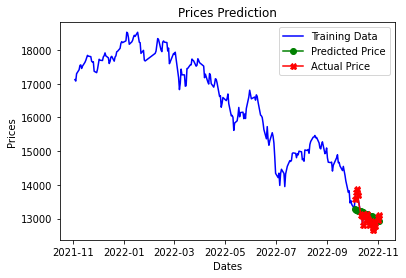

In [66]:
# Plot actual data and predicted data
plt.plot(data_close, color = 'blue', label = 'Training Data')
plt.plot(test.index, forecasts, color = 'green', marker = 'o', label = 'Predicted Price')
plt.plot(test.index, test_close, color = 'red', marker = "X", label = 'Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
# conf_int = np.asarray(confidence_intervals)
# plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], alpha=0.9, color='orange', label="Confidence Intervals")
plt.legend()
plt.show()
